# Heston Model Calibration - Brazilian Options
\
This document is a personal research project. Please note that its purpose is purely for **knowledge application** and **not** an incentive to invest or hedge funds using it.

The Data was downloaded on March 26, 2025, focusing on options expiring April 17, 2025.

\
The project is divided into the following steps:

* **Step 1:** Defining auxiliary functions to fetch price data and perform basic calculations.

* **Step 2:** Fetching the data and performing the necessary calculations and transformations.

* **Step 3:** Plotting the Volatility Smile for a given maturity.

* **Step 4:** Defining the Heston Model function using the Monte Carlo approach.

* **Step 5:** Estimating the initial parameters for model calibration.

* **Step 6:** Defining the error function to be minimized during calibration.

* **Step 7:** Performing the calibration—optimizing the model parameters.

* **Step 8:** Visualizing and validating the results.

* **Step 9:** Using the calibrated parameters to simulate Heston paths.

* **Step 10:** Using the simulations to compute Value-at-Risk (VaR).

* **Step 11:** Comparing VaR estimates across different calculation methods.





---



## **Step 1** : **Defining auxiliary functions to fetch price data and perform basic calculations**

In [ ]:
# Libraries
import yfinance as yf
from datetime import datetime
import requests
import numpy as np
import pandas as pd
from scipy.stats import norm
from typing import Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.simplefilter("ignore")

######     Getting the underlying asset historical data
######
def download_ibov_data(ticker='BOVA11.SA', start='2019-01-01', end=None):
    data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust = True)
    data = data.xs((ticker), level="Ticker", axis=1)['Close'].to_frame()
    data['Returns'] = data.pct_change()
    data['Log Returns'] = np.log(1 + data['Returns'])
    return data.dropna()

######     Getting the risk-free rate from BCB
######
def get_selic(code = 1178):
    # Brazilian Central Bank (BCB) Time Series Management System:
    # SELIC (p.d.)          code : 11
    # SELIC (p.y.)          code : 1178
    # SELIC target (p.y.)   code : 432

    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{code}/dados/ultimos/1?formato=json"

    # Fetch data
    response = requests.get(url)
    data = response.json()

    # Extract the latest SELIC value (in %)
    selic_value = float(data[0]['valor'])

    return selic_value/100

######     Getting the current options pricing data
######
def get_options_data(ticker)-> Tuple[pd.DataFrame, np.ndarray]:
    """
    Parameters:
      ticker  : Underlying asset ticker

    Return    : Dataframe with options data from opcoes.net.br
              : List of available maturities

    """
    url = f'https://opcoes.net.br/listaopcoes/completa?idAcao={ticker}&listarVencimentos=true&cotacoes=true'
    response = requests.get(url, verify=False).json()

    ## List of option expiration dates
    exp_dates = [date['value'] for date in response['data']['vencimentos']]


    options = []
    ## Get the options for each exp. date
    for exp in exp_dates:
      url=f'https://opcoes.net.br/listaopcoes/completa?idAcao={ticker}&listarVencimentos=false&cotacoes=true&vencimentos={exp}'
      response = requests.get(url).json()

      if response['success']:
        options += [[ticker, exp, info[0].split('_')[0], info[2], info[3], info[5], info[8]] for info in response['data']['cotacoesOpcoes']]
               ## info[0]  : Option ticker
               ## info[2]  : Option type [CALL, PUT]
               ## info[3]  : Option Expiration type [A, E] (American or European)
               ## info[5]  : Option Strike
               ## info[8]  : Option last price
      else:
        print(f'Expiration: {exp} failed!')

    ## Build a DataFrame
    columns = ['Underlying','Expiration','Opt Ticker', 'Type', 'Type Exp', 'Strike', 'Price']
    options = pd.DataFrame(options, columns=columns)
    options['Expiration'] = pd.to_datetime(options['Expiration'], errors='coerce')

    return options, exp_dates

######     Pricing options under Black-Scholes (analytical solution)
######
def black_scholes_price(S, K, T, r, sigma, op_type):
    """
    Parameters:
      S       : Asset price
      K       : Strike price
      T       : Time to maturity
      r       : risk-free rate
      sigma   : volatility
      op_type : 'CALL' or 'PUT'

    Return    : Option price

    """

    ## Cumulative distribution function of the standard normal distribution
    N = norm.cdf

    ## Black-Scholes Formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)


    ## Check the option type and compute the payoff
    if op_type == 'CALL':
        op_price = S * N(d1) - N(d2) * K * np.exp(-r * T)
    elif op_type == 'PUT':
        op_price = K * np.exp(-r * T) * N(-d2) - S * N(-d1)
    else:
        raise ValueError("op_type must be 'CALL' or 'PUT'!")

    return op_price

######     Using BS to compute Implied Volatility from a price input
######
###### (Bisection method is stable but slower alternative to Newton-Raphson)
def implied_volatility_bisection(P, op_type, S, K, T, r, tol=1e-4, max_iter=200):
    """
    Compute implied volatility using the bisection method.

    Parameters:
      P        : Observed option price
      op_type  : 'CALL' or 'PUT'
      S        : Asset price
      K        : Strike
      T        : Time to Maturity
      r        : Risk-free rate
      tol      : Error tolerance
      max_iter : Max iterations for bisection

    Return:
      Implied volatility (%) or np.nan if not converged
    """
    if T == 0:
        return 0

    # Initial bounds
    lower_bound, upper_bound = 1e-6, 5

    for _ in range(max_iter):
        sigma = (lower_bound + upper_bound) / 2
        price = black_scholes_price(S, K, T, r, sigma, op_type)

        if abs(price - P) < tol:
            return sigma

        if price > P:
            upper_bound = sigma
        else:
            lower_bound = sigma

    return np.nan  # Not converged


## **Step 2 : Fetching the data and performing the necessary calculations and transformations.**

### **Underlying Asset**

* Using the ETF **BOVA11** as the proxy to Ibovespa market index.
* Computing the rolling standard deviation with a 1-year window (252 trading days).
* Setting the current price as the last closing value in the DataFrame.

In [ ]:
# Creating DataFrame of IBOV returns
ibov_df = download_ibov_data()

# Compute rolling std using a 252-day window (1 trading year)
ibov_df['Rolling std'] = ibov_df['Log Returns'].rolling(window=252).std().bfill()
bova_last_price = ibov_df['Close'][-1]

print(f"The last price of BOVA11 is: R$ {bova_last_price:.2f}")

The last price of BOVA11 is: R$ 126.29


In [ ]:
ibov_df.describe()

,Close,Returns,Log Returns,Rolling std
count,1550.000000,1550.000000,1550.000000,1550.000000
mean,108.423697,0.000356,0.000234,0.014586
std,12.750111,0.015569,0.015715,0.005938
min,61.139999,-0.145747,-0.157528,0.007664
25%,99.580002,-0.007241,-0.007267,0.011709
50%,108.869999,0.000873,0.000872,0.013088
75%,118.079998,0.008339,0.008304,0.014157
max,133.619995,0.133951,0.125708,0.028476


### **Options Data**
\
* Fetching options data from from [opcoes.net.br](opcoes.net.br)
* Filtering for European-style options only
* Calculating the Time To Maturity (TTM) in years.
* Estimating Implied Volatility (IV) based on market prices.

In [ ]:
bova_options, exp_dates = get_options_data('BOVA11')

## Selecting only European options
bova_euro_options = bova_options[bova_options['Type Exp'] == 'E'].copy().dropna().reset_index(drop=True)
bova_euro_options.head()

,Underlying,Expiration,Opt Ticker,Type,Type Exp,Strike,Price
0,BOVA11,2025-04-17,BOVAD1,CALL,E,105.0,21.86
1,BOVA11,2025-04-17,BOVAD3,CALL,E,121.0,5.84
2,BOVA11,2025-04-17,BOVAD5,CALL,E,123.0,4.00
3,BOVA11,2025-04-17,BOVAD6,CALL,E,129.0,0.25
4,BOVA11,2025-04-17,BOVAD11,CALL,E,115.0,11.79


In [ ]:
## Compute time to maturity (TTM) in years
analysis_date = pd.to_datetime('2025-03-26').date()
bova_euro_options['TTM'] = np.where(
    bova_euro_options['Expiration'].dt.date <= analysis_date,  # Condition
    0,  # If today is the expiration day
    (bova_euro_options['Expiration'] - pd.to_datetime(analysis_date)).dt.days / 365.25  # Otherwise, compute TTM in years
)

# Risk-free rate from BCB
r = get_selic()

## Compute implied volatility from market prices
bova_euro_options['Implied Vol'] = bova_euro_options.apply(
    lambda row: implied_volatility_bisection( P=row['Price'],
                                    S=bova_last_price,
                                    op_type=row['Type'],
                                    K=row['Strike'],
                                    T=row['TTM'],
                                    r= r),
    axis=1
)

# Group by expirations and counting options
bova_euro_options = bova_euro_options.dropna()
bova_euro_options['Expiration'].value_counts().sort_index()


,count
Expiration,
2025-04-17,137
2025-04-25,63
2025-05-02,24
2025-05-09,10
2025-05-16,150
2025-05-23,3
2025-06-06,1
2025-06-13,6
2025-06-20,107


### **(Alternatively) Load .pkl Files**

Used for **reproducibility**, by loading locally stored files from the previous steps on an earlier date.

In [ ]:
import pickle

# Load BOVA Options data
with open("/content/bova_euro_options_mar.pkl", "rb") as f:
    bova_euro_options = pickle.load(f)

# Load IBOV DataFrame
with open("/content/ibov_df_mar.pkl", "rb") as f:
    ibov_df = pickle.load(f)

bova_last_price = ibov_df['Close'].iloc[-1]

## **Step 3: Plotting the Volatility Smile for a given maturity.**

With the computed IV values, we plot how volatility varies with strike price for put options. Typically, IV is higher for deep ITM and OTM options than for ATM ones, forming a smile.

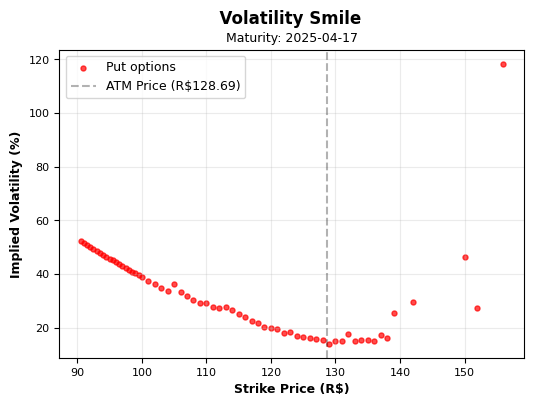

In [ ]:
## Chose Maturity
mat = '2025-04-17'
options = bova_euro_options[bova_euro_options['Expiration'] == mat].copy().reset_index(drop=True)

## Dividing put and call options
df_put  = options[options['Type'] == 'PUT'].copy().reset_index(drop=True)
df_call  = options[options['Type'] == 'CALL'].copy().reset_index(drop=True)

## Create figure and axis
fig, ax = plt.subplots(figsize=(6,4))

## Selecting closer range strikes to plot
df_plot = df_put[ df_put["Strike"] > (bova_last_price * 0.7)] # Filter out lower strikes
df_plot = df_plot[ df_plot["Strike"] < (bova_last_price * 1.3)] # Filter out higher strikes

## Add puts
ax.scatter(df_plot["Strike"], df_plot["Implied Vol"]*100, s=13,color="red", label='Put options', alpha=0.7)

## Add ATM price line
ax.axvline(x=bova_last_price, color="black", linestyle="--", label=f"ATM Price (R${bova_last_price:.2f})", alpha = 0.3)

## Customizing axis
ax.set_xlabel("Strike Price (R$)", fontsize=9, fontweight='semibold')
plt.xticks(fontsize=8)
ax.set_ylabel("Implied Volatility (%)", fontsize=9, fontweight='semibold')
plt.yticks(fontsize=8)

## Customizing plot
plt.suptitle("  Volatility Smile", fontweight='bold' )
plt.title(f"Maturity: {mat}", fontsize=9)
ax.legend(fontsize=9, loc='upper left')
ax.grid(alpha=0.25)

## Show plot
plt.show()

In the plot, we see this smile-like curve, with some deviations that may indicate mispriced options. Notably, OTM options show more noise, a common issue in low-liquidity strikes where prices may not fully reflect fair value. This highlights IV estimation challenges in less active markets.



---



## **Step 4: Defining the Heston Model function using the Monte Carlo approach.**

Unlike Black-Scholes, Heston assumes volatility follows a mean-reverting stochastic process, making it better suited for real markets, especially in less liquid environments where volatility dynamics play a crucial role.

The following equations represent the **discretized** form of the Heston Model:

\begin{equation*}
    S_{t+1} = S_{t} e^{\left( r - \frac{\nu_t}{2} \right) dt + \sigma \sqrt{\nu_t} dZ_1}
\end{equation*}

\begin{equation*}
    \nu_{t+1} = \nu_{t} + \kappa \left( \theta - \nu_{t} \right) dt + \sigma \sqrt{\nu_{t}}dZ_2
\end{equation*}


In [ ]:
def Heston_Model(vol_par: Dict[str, float], S0, r, rho, T, M=250, Iter=10000) -> Tuple[np.ndarray, np.ndarray]:
    """
        Calculate the stochastic volatility and underlying stock price using the Heston model.

    Parameters:
        vol_par(dict)
            'V0'    : inicial variance
            'kappa' : mean reversion speed
            'theta' : long-term variance
            'sigma' : volatility of volatility

        K (float)     : Strike price of the option.
        r (float)     : Risk-free interest rate.
        T (float)     : Time to maturity.
        Iter (int)    : Number of iterations - Monte Carlo (MC) simulations

    Returns:
        St (array): The stock price for each time step for each MC simulation.
        Vt (array): The volatility value for each time step for each MC simulation.

    """

    ## Seed for reproducibility
    np.random.seed(42)

    ## Covariance Matrix
    covariance_matrix = np.zeros((2, 2))
    covariance_matrix[0] = [1.0, rho]
    covariance_matrix[1] = [rho, 1.0]
    cho_matrix = np.linalg.cholesky(covariance_matrix)

    ## Time step
    dt = T / M

    ## Inicialize volatility matrix (number time steps x number of paths)
    Vt = np.full([M + 1, Iter], vol_par['V0'], dtype=float)
    row_vt = 1

    ## Inicialize Stock matrix (number time steps x number of paths)
    St = np.full([M + 1, Iter], S0, dtype=float)
    row_st = 0

    ## Random matrix generation
    z = np.random.standard_normal((2, M+1, Iter))

    ## Looping through time steps
    for t in range(1, M + 1):
        ### Generate correlated random numbers using the Cholesky decomposition matrix
        z1 = np.dot(cho_matrix, z[:, t])

        ### (Non-negative) discretized SDEs
        Vt[t] = np.maximum(0, Vt[t-1] + vol_par['kappa'] * (vol_par['theta'] - Vt[t-1]) * dt + np.sqrt(Vt[t - 1]) * vol_par['sigma'] * z1[row_vt] * np.sqrt(dt))
        St[t] = np.maximum(0, St[t-1] * np.exp((r - 0.5 * Vt[t-1]) * dt + np.sqrt(Vt[t-1]) * z1[row_st] * np.sqrt(dt)))

    return St, Vt


def heston_op_price(S,K,r,T, op_type):
    """
    Calculate the option price using the Heston model.

    Parameters:
        S (np.ndarray) : Simulated asset price paths.
        K (float)      : Strike price of the option.
        r (float)      : Risk-free interest rate.
        T (float)      : Time to maturity.
        op_type (str)  : Type of option, either 'call' or 'put'.

    Returns:
        float: The computed option price.

    Raises:
        ValueError: If `op_type` is not 'call' or 'put'.
    """

    ## Check the option type and compute the payoff
    if op_type == 'CALL':
        payoff = np.maximum(0, S[-1,:] - K)
    elif op_type == 'PUT':
        payoff = np.maximum(0, K - S[-1,:])
    else:
        raise ValueError("op_type must be 'CALL' or 'PUT'!")

    ## Averaging and discounting
    average = np.mean(payoff)
    op_price = np.exp(-r*T)*average

    return op_price

## **Step 5: Estimating the initial parameters for model calibration.**

Before calibration, we need reasonably estimate its parameters. Here's how I derive them based on historical data:

* **Initial Variance (v₀):** estimated by annualizing the most recent rolling volatility value. This reflects the current level of market volatility.

* **Long-Term Variance (θ):** Used the average of the annualized rolling std over the sample period (~5 years) and square it.

* **Volatility of Volatility (σ):** Inferred from the std of daily changes in the log of variance then it's annualized.

* **Correlation (ρ):** Calculated as the correlation between asset returns and changes in variance, capturing the relationship between price movements and volatility shifts.

* **Mean Reversion Speed (κ):** The parameter κ, which controls how quickly variance reverts to its mean, is set arbitrarily to a moderate value (0.5). This parameter will be refined during the calibration process.

\
*Note:* The Inicial Variance (v₀) is not packed to be calibrated as it is -- in my view -- a observed parameter rather a model coefficient to be optimized.



In [ ]:
## Initial volatility (v0)
std_anual = ibov_df['Rolling std'].iloc[-1]*np.sqrt(252) # Annualized vol
v0 = std_anual** 2

## Long-term variance (θ)
std_anual_avg = (ibov_df['Rolling std']).mean()*np.sqrt(252) # Average annualized vol
theta = std_anual_avg**2

## Volatility of Volatility (σ)
log_var_changes = np.diff(np.log(ibov_df['Rolling std'] ** 2)) # daily changes in log-var
sigma_v = np.std(log_var_changes)* np.sqrt(252) # Vol of vol annualized

## Correlation (ρ)
vol_diff = np.diff(ibov_df['Rolling std'] ** 2)
returns = ibov_df['Log Returns'].iloc[:-1]  # Align with diff length since np.diff reduces the length by 1
rho = np.corrcoef(returns, vol_diff)[0, 1]

## Choosing Kappa arbitrary:
kappa = 0.5

# Pack parameters into a tuple (v0 is not calibrated!)
ini_param = (kappa, theta, sigma_v, rho)

# Print results
print('Initial parameters:')
print(f'v0 : {v0:.8f}')
print(f'θ  : {theta:.8f}')
print(f'κ  : {kappa:.8f}')
print(f'σ  : {sigma_v:.8f}')
print(f'ρ  : {rho:.8f}')


Initial parameters:
v0 : 0.02078874
θ  : 0.05391368
κ  : 0.50000000
σ  : 0.28795604
ρ  : -0.06999432


## **Step 6: Defining the error function to be minimized during calibration.**

Measure the difference between observed and modeled option prices, while accounting for constraints:
* Volatility parameters above a minimum threshold.
* Non-negativity of Mean Reversion Speed (κ)
* Correlation between -1 and < 1

In [ ]:
from scipy.optimize import minimize

def Error_function(ini_par, options, S0, r):
  """
    # Parameters:
      (tuple) ini_par  : Inicial parameters for minimizing
          - ini_par[0] : kappa : mean-reversion factor
          - ini_par[1] : theta : long-run mean of variance
          - ini_par[2] : sigma_v : volatility of variance
          - ini_par[3] : rho     : correlation between variance and stock prices
          - ini_par[4] : v0      : initial variance

      (DataFrame) options : options price data - required columns ["TTM", "Price", "Strike"]

    # Returns:
      (float) MSE      : Mean Squared Error - Squared difference between the model and market price

  """
  ## Aux variables
  global i, min_MSE

  ## Unpack parameters
  kappa, theta, sigma_v, rho = ini_par

  # Construct a dictionary from the tuple (Used in Heston price function)
  vol_dict = {'V0': v0, 'kappa': kappa, 'theta': theta, 'sigma': sigma_v, 'rho': rho}

  ## Parameter constraints
  if kappa < 0.0 or theta < 0.0005 or sigma_v < 0.0005 or rho < -1.0 or rho > 1.0:
      return 500.0  # Large penalty for invalid parameters

  ## Inicialize error list
  s_err = []

  ## Loop through market options data
  for row, option in options.iterrows():

      ### Heston pricing
      St, _ = Heston_Model(vol_dict, S0, r, rho, option["TTM"], M=51, Iter=5000)
      model_value = heston_op_price(St, option["Strike"], r, option["TTM"], 'CALL' )

      #### Compute squared error
      s_err.append((model_value - option["Price"]) ** 2)


  ##  Mean Squared Error (MSE)
  MSE = np.mean(s_err)

  ## Update minimum MSE
  min_MSE = min(min_MSE, MSE)

  ## Print progress every 10 iterations
  if i % 10 == 0:
    ###     iteration, vol parameters, current MSE, min MSE
    print("%4d |" % i, np.array(ini_par), "| %7.3f | %7.3f" % (MSE, min_MSE))

  i += 1

  return MSE

## **Step 7: Performing the calibration — optimizing the model parameters.**

Use SciPy and numerical optimization techniques to minimize pricing errors. While Fourier transform methods (e.g., FFT-based pricing via characteristic functions) offer greater computational efficiency and stability, this implementation prioritizes simplicity and transparency in the calibration process.


1. We begin by filtering the options to focus on those that are near-the-money (ATM), as they tend to be more liquid -- therefore more efficient pricing -- and provide better signals for calibration.

2. Next, we separate the dataset into PUT and CALL options to allow for independent modeling and analysis.
3. We perform the calibration process using only call options.
4. Finally, we extract the calibrated parameters, display the final calibration error (MSE), and the iterations information.


In [ ]:
## Filter options near ATM
perc = 0.10  # Percent around current price
S0 = bova_last_price
options_df = bova_euro_options[(np.abs(bova_euro_options["Strike"] - S0) / S0) < perc]

## Dividing put and call options
df_put  = options_df[options_df['Type'] == 'PUT'].copy().reset_index(drop=True)
df_call  = options_df[options_df['Type'] == 'CALL'].copy().reset_index(drop=True)

# Risk-free rate from BCB
r = get_selic()

# Iterations over error function
i = 0
# Initial min error
min_MSE = 500

## Begin calibration
calibration = minimize(Error_function, ini_param, args=(df_call, bova_last_price, r), method='Nelder-Mead', tol=1e-3)

## Show calibrated parameters
calibrated_params = calibration.x
print('Calibrated parameters:\n', calibrated_params)

## Show metrics
final_mse = calibration.fun
print('Final MSE:\n', final_mse)
print('Iterations: ', calibration.nit)

## Dict of Calibrated Volatility parameters
calibrated_dict = {'V0':v0, 'kappa': calibrated_params[0], 'theta': calibrated_params[1],
                'sigma': calibrated_params[2], 'rho': calibrated_params[3]}

rho= calibrated_params[3]


   0 | [ 0.5         0.05391368  0.28795604 -0.06999432] |   0.435 |   0.435
  10 | [ 0.50273437  0.04683751  0.32102599 -0.07147077] |   0.385 |   0.385
  20 | [ 0.49570274  0.00337059  0.44950489 -0.07567725] |   0.274 |   0.270
  30 | [ 0.53359205  0.00748905  0.41545859 -0.07251753] |   0.269 |   0.269
  40 | [ 0.5608112   0.00857414  0.364373   -0.05912772] |   0.264 |   0.264
  50 | [ 0.57319457  0.00154096  0.30124872 -0.03976044] |   0.260 |   0.259
  60 | [ 0.53558489  0.0011351   0.30168133 -0.03731875] |   0.259 |   0.259
  70 | [ 0.51067041  0.00161151  0.29313939 -0.03484354] |   0.259 |   0.259
  80 | [ 0.48285256  0.00127208  0.3159216  -0.0425682 ] |   0.258 |   0.258
  90 | [ 0.47735761  0.00142035  0.30355023 -0.03859672] |   0.258 |   0.258
 100 | [ 0.47408904  0.00053034  0.29486214 -0.0358409 ] |   0.258 |   0.258
 110 | [ 0.47820196  0.00082127  0.29768392 -0.03660066] |   0.258 |   0.258
 120 | [ 0.47704598  0.0007785   0.29706026 -0.03645304] |   0.258 |   0.258

#### **Model Parameters:**

So, these are the parameters resulting from calibration of the Heston model:

- $\kappa_\nu = 0.4745$
- $\theta_\nu = 0.0007$
- $\sigma_\nu = 0.2964$
- $\rho = -0.0363$
- $\nu_0 = 0.0208$


## **Step 8: Visualizing and validating the results.**

In [ ]:
## Specifying the Maturity
mat = '2025-05-16'
options_df = bova_euro_options[bova_euro_options['Expiration'] == mat].copy().reset_index(drop=True)

## Redefining put and call dataFrames
df_put  = options_df[options_df['Type'] == 'PUT'].copy().reset_index(drop=True)
df_call  = options_df[options_df['Type'] == 'CALL'].copy().reset_index(drop=True)

## Defining T
analysis_date = pd.to_datetime('2025-03-26').date()
mat = pd.to_datetime('2025-05-16').date()
T = (mat - analysis_date).days / 365.25


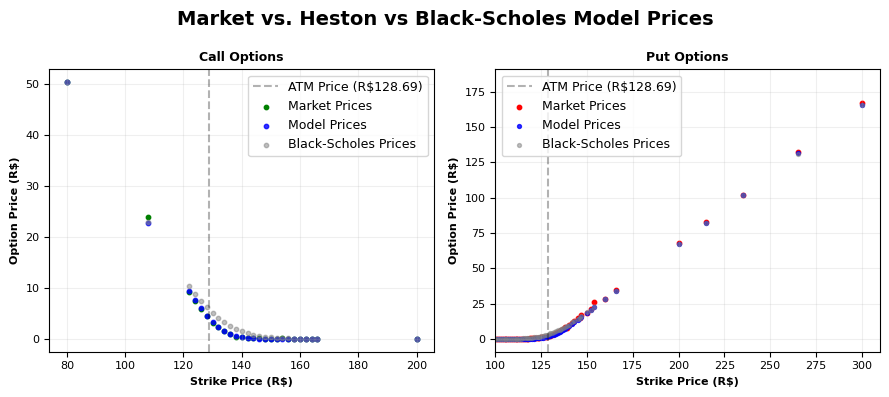

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

## Defining axes
call = axes[0]
put  = axes[1]

## Historical annual volatility for Black-Scholles comparison
vol_bova = ibov_df['Rolling std'].mean()*np.sqrt(252)

## Listing Stikes
strikes_call = df_call["Strike"].tolist()
strikes_put = df_put["Strike"].tolist()

## Listing Prices
market_prices_call = df_call["Price"].tolist()
market_prices_put = df_put["Price"].tolist()


## -------------------  CALL OPTIONS --------------------------
##
## Compute model with calibrated parameters for Call Options
S_sim, V_sim = Heston_Model(calibrated_dict, bova_last_price, r, rho, T)
model_prices_call = [heston_op_price(S_sim, K, r, T, 'CALL') for K in strikes_call]
bs_prices_call = [black_scholes_price(bova_last_price, K, T, r, vol_bova, 'CALL') for K in strikes_call]

## Add ATM price line
call.axvline(x=bova_last_price, color="black", linestyle="--", label=f"ATM Price (R${bova_last_price:.2f})", alpha = 0.3)

## Market vs Model prices - Call Options
call.scatter(strikes_call, market_prices_call, s=10, label="Market Prices", color="green")
call.scatter(strikes_call, model_prices_call, s=10, label="Model Prices", color="blue", alpha=0.8)
call.scatter(strikes_call, bs_prices_call, s=10, label="Black-Scholes Prices", color="grey", alpha=0.5)


## Customize subplot 1
call.set_xlabel("Strike Price (R$)", fontweight='semibold',fontsize = 8)
call.set_ylabel("Option Price (R$)", fontweight='semibold', fontsize = 8)
call.set_title('Call Options', fontweight='semibold',fontsize = 9)
call.tick_params(axis='both', labelsize=8)
#call.set_xlim(120, 180)
call.legend(fontsize = 9)
call.grid(alpha=0.2)

## -------------------  PUT OPTIONS --------------------------
##
## Compute model with calibrated parameters for Put Options
S_sim, V_sim = Heston_Model(calibrated_dict, bova_last_price, r, rho, T)
model_prices_put = [heston_op_price(S_sim, K, r, T, 'PUT') for K in strikes_put]
bs_prices_put = [black_scholes_price(bova_last_price, K, T, r, vol_bova, 'PUT') for K in strikes_put]

## Add ATM price line
put.axvline(x=bova_last_price, color="black", linestyle="--", label=f"ATM Price (R${bova_last_price:.2f})", alpha = 0.3)

## Market vs Model prices - Put Options
put.scatter(strikes_put, market_prices_put, s=10, label="Market Prices", color="red")
put.scatter(strikes_put, model_prices_put, s=8, label="Model Prices", color="blue",alpha=0.8)
put.scatter(strikes_put, bs_prices_put, s=8, label="Black-Scholes Prices", color="grey", alpha=0.5)


## Customize subplot 2
put.set_xlabel("Strike Price (R$)", fontweight='semibold',fontsize = 8)
put.set_ylabel("Option Price (R$)", fontweight='semibold', fontsize = 8)
put.set_title('Put Options', fontweight='semibold',fontsize = 9)
put.tick_params(axis='both', labelsize=8)
put.set_xlim(100, 310)
put.legend(fontsize = 9, loc='upper left')
put.grid(alpha=0.2)

## Add title and show the figure
fig.suptitle("Market vs. Heston vs Black-Scholes Model Prices", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


The following observations are made:

◾ Model prices (blue) remain close to market prices (green), reinforcing that stochastic volatility improves pricing accuracy compared to Black-Scholes.

◾ The Black-Scholes model (gray dots) systematically mispriced options, particularly around the ATM region, where it struggles to capture the volatility smile.

◾ Discrepancies exist for some OTM options, likely due to market liquidity constraints and implied volatility estimation challenges.

◾ The Heston Model achieves a low error (MAE = 0.09, MSE = 0.05), suggesting it effectively fits market data.

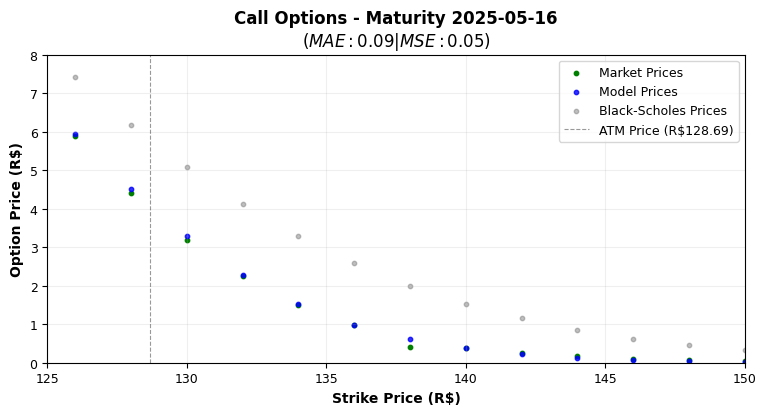

In [ ]:
# Create a figure with two subplots
fig, call = plt.subplots(figsize=(9, 4))

## Market vs Model prices - Call Options
call.scatter(strikes_call, market_prices_call, s=10, label="Market Prices", color="green")
call.scatter(strikes_call, model_prices_call, s=10, label="Model Prices", color="blue", alpha=0.8)
call.scatter(strikes_call, bs_prices_call, s=10, label="Black-Scholes Prices", color="grey", alpha=0.5)

## Add ATM price line
call.axvline(x=bova_last_price, color="black", linewidth=0.8, linestyle="--", label=f"ATM Price (R${bova_last_price:.2f})", alpha = 0.4)

## Convert lists to arrays
market_prices_call = np.array(market_prices_call)
model_prices_call = np.array(model_prices_call)

## Compute metrics
mae = np.mean(np.abs(market_prices_call - model_prices_call))
mse = np.mean((market_prices_call - model_prices_call)**2)

## Customize plot
call.set_xlabel("Strike Price (R$)", fontweight='semibold',fontsize = 10)
call.set_ylabel("Option Price (R$)", fontweight='semibold', fontsize = 10)
call.set_title(f'Call Options - Maturity {mat}\n$(MAE: {mae:.2f} | MSE: {mse:.2f})$',
              fontweight='semibold', fontsize=12)

call.tick_params(axis='both', labelsize=9)
call.legend(fontsize = 9)
call.grid(alpha=0.2)

## Zoom effect
call.set_xlim(125, 150)
call.set_ylim(0, 8);



---



## **Step 9: Using the calibrated parameters to simulate Heston paths.**

To assess the behavior of asset prices and their volatility under the Heston model, we simulate 10,000 stochastic paths using the previously calibrated parameters. Then, we randomly select 100 paths to visualize, keeping the plots clean and interpretable.

The simulation is carried out for a period of 252 trading days (1 year), using the Heston_Model function.

The results are displayed in two Figures:

* The first plot shows the evolution of 100 simulated underlying asset prices (BOVA11) in the left panel. On the right side, a histogram displays the distribution of final prices for 10000 simulations.

* The second plot shows the evolution of 100 simulated volatility paths (in percentage terms) in the left panel. On the right side, a histogram displays the distribution of final volatility values for 10000 simulations.



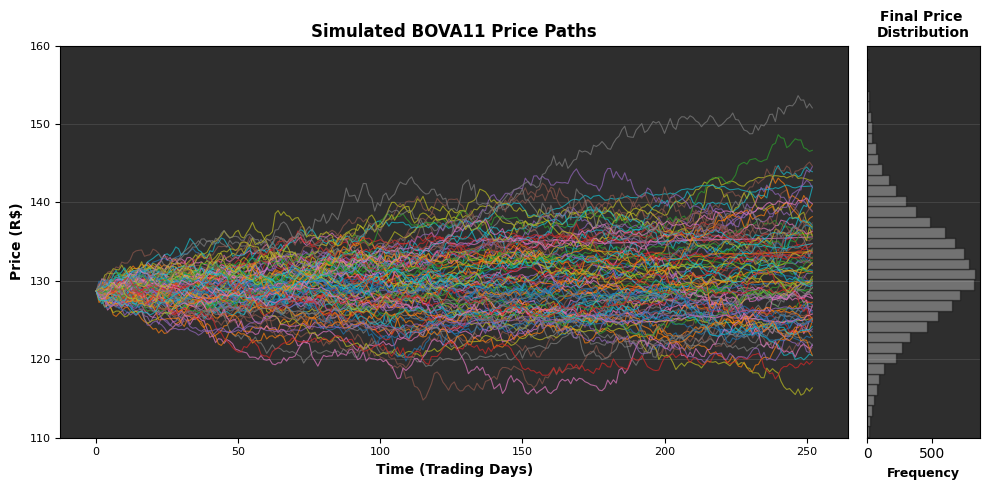

In [ ]:
## Define number of total simulations and the number to plot
total_paths = 10000
paths_to_plot = 100

## Simulate 10,000 paths
S_sim, V_sim = Heston_Model(calibrated_dict, bova_last_price, r, rho, T, M=252, Iter=total_paths)

## Select 100 random paths to plot
indices = np.random.choice(total_paths, paths_to_plot, replace=False)



## Create figure for BOVA11 paths with histogram
fig1, St = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [7, 1]})

# Set background color
St[0].set_facecolor('#2e2e2e')
St[1].set_facecolor('#2e2e2e')

# Plot 100 selected underlying asset price paths
St[0].plot(S_sim[:, indices], lw=0.8, alpha=0.7)
St[0].set_title("Simulated BOVA11 Price Paths", fontweight='bold')
St[0].set_xlabel("Time (Trading Days)", fontweight='semibold')
St[0].set_ylabel("Price (R$)", fontweight='semibold')
St[0].tick_params(axis='both', labelsize=8)
St[0].grid(axis = 'y', alpha=0.1,color = 'white')
St[0].set_ylim(110,160)

# Add histogram of all end values
St[1].hist(S_sim[-1, :], bins=50, orientation='horizontal', alpha=0.4, color='#d9d9d9', edgecolor='black')
St[1].set_title("Final Price \nDistribution", fontweight='semibold', fontsize = 10)
St[1].set_xlabel("Frequency", fontweight='semibold',fontsize = 9)
St[1].grid(axis = 'y', alpha=0.1, color = 'white')
St[1].sharey(St[0])
St[1].tick_params(axis='y', which='both', left=False, labelleft=False)

plt.tight_layout()

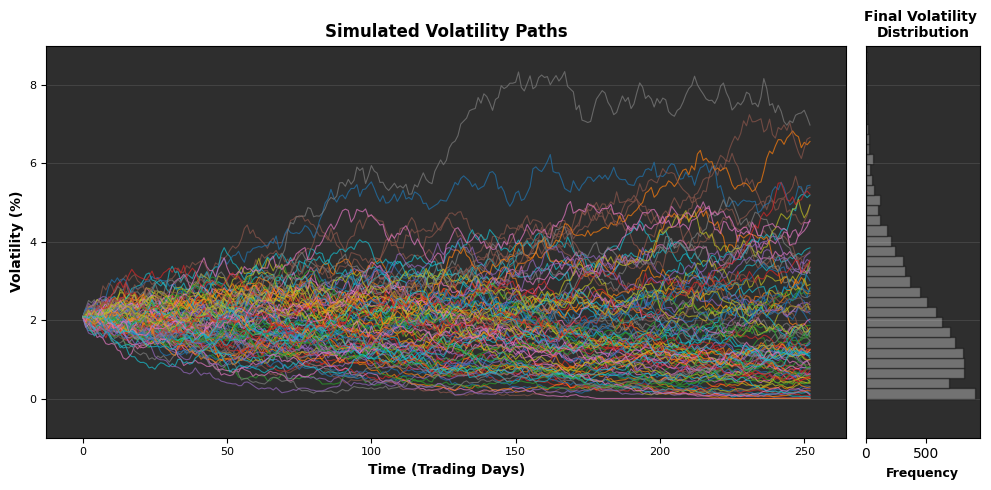

In [ ]:
## Create figure for Volatility paths with histogram
fig2, Vt = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [7, 1]})

# Set background color
Vt[0].set_facecolor('#2e2e2e')
Vt[1].set_facecolor('#2e2e2e')

# Plot 100 selected volatility paths
Vt[0].plot(V_sim[:, indices]*100, lw=0.8, alpha=0.7)
Vt[0].set_title("Simulated Volatility Paths", fontweight='bold')
Vt[0].set_xlabel("Time (Trading Days)", fontweight='semibold')
Vt[0].set_ylabel("Volatility (%)", fontweight='semibold')
Vt[0].tick_params(axis='both', labelsize=8)
Vt[0].grid(axis = 'y', alpha=0.1, color = 'white')
Vt[0].set_ylim(-1,9)


# Add histogram of all end values
Vt[1].hist(V_sim[-1, :]*100, bins=50, orientation='horizontal', alpha=0.4, color='#d9d9d9', edgecolor='black')
Vt[1].set_title("Final Volatility \nDistribution", fontweight='semibold', fontsize = 10)
Vt[1].set_xlabel("Frequency", fontweight='semibold', fontsize = 9)
Vt[1].grid(axis = 'y', alpha=0.1, color = 'white')
Vt[1].sharey(Vt[0])
Vt[1].tick_params(axis='y', which='both', left=False, labelleft=False)

plt.tight_layout()
plt.show()

This visualization helps illustrate how the Heston model captures both the random movement of prices and the changing volatility over time. This characteristic is what makes the Heston Model stand out compared to simpler models like Black-Scholes.

\


---



## **Step 10: Using the simulations to compute Value-at-Risk (VaR).**

Value at Risk (VaR) is a statistical risk management technique measuring the maximum loss that an investment portfolio is likely to face within a specified time frame with a certain degree of confidence. Two approaches are used to compute this metric:

1. Parametric:
  * Assumes returns are normally distributed
  * Simple and computationally efficient

2. Nonparametric:
  * Historical data
  * Monte Carlo simulation

In [ ]:
from scipy.stats import norm

## Auxiliary functions for computing VaR using different methods

def historical_var(returns, confidence_level=0.95):
    var = np.percentile(returns, (1 - confidence_level) * 100)
    return var


def parametric_var(returns, std=None, confidence_level=0.95):
    mean_return = np.mean(returns)
    std_dev = np.std(returns) if std is None else std
    z_score = norm.ppf(1 - confidence_level)
    var = mean_return + z_score * std_dev

    return var

In [ ]:
# Compute different VaR metrics
hist_var = historical_var(ibov_df['Returns'])
param_var = parametric_var(ibov_df['Returns'])
param_var_rol = parametric_var(ibov_df['Returns'],std=max(ibov_df['Rolling std']))

print('VaR - 95% Confidence')
print(f'\nHistorical VaR: {hist_var*100:.2f}%')
print(f'Parametric VaR (std = all data): {param_var*100:.2f}%')
print(f'Parametric VaR (std = max 1 year rolling window): {param_var_rol*100:.2f}%')

VaR - 95% Confidence

Historical VaR: -2.16%
Parametric VaR (std = all data): -2.52%
Parametric VaR (std = max 1 year rolling window): -4.65%


While VaR tells you the maximum expected loss at a given confidence level (95% in this work), CVaR goes further by calculating the average loss in the worst 5% of cases.

In [ ]:
# Compute Expected Shortfall (Conditional VaR)
es_hist = ibov_df['Returns'][ibov_df['Returns'] <= hist_var].mean()
es_param = ibov_df['Returns'][ibov_df['Returns'] <= param_var].mean()
es_param_rol = ibov_df['Returns'][ibov_df['Returns'] <= param_var_rol].mean()

# Display Results
print('\nExpected Shortfall - 95% Confidence\n')
print(f'Historical ES: {es_hist*100:.2f}%')
print(f'Parametric ES (std = all data): {es_param*100:.2f}%')
print(f'Parametric ES (std = max 1 year rolling window): {es_param_rol*100:.2f}%')



Expected Shortfall - 95% Confidence

Historical ES: -3.62%
Parametric ES (std = all data): -4.35%
Parametric ES (std = max 1 year rolling window): -8.23%


#### Heston Paths VaR metrics:

In [ ]:
# Compute log returns for each simulated path
log_returns = np.log(S_sim[-1, :] / bova_last_price)

# Compute the 5th percentile (95% confidence level)
Heston_var = np.percentile(log_returns, 5)

print(f'Heston Model VaR: {Heston_var*100:.2f}%')

# Compute Expected Shortfall (Conditional VaR)
ES_95 = log_returns[log_returns <= Heston_var].mean()
print(f'Heston Model Expected Shortfall (95%): {ES_95*100:.2f}%')

Heston Model VaR: -6.94%
Heston Model Expected Shortfall (95%): -9.52%


## **Step 11: Comparing VaR estimates across different calculation methods.**

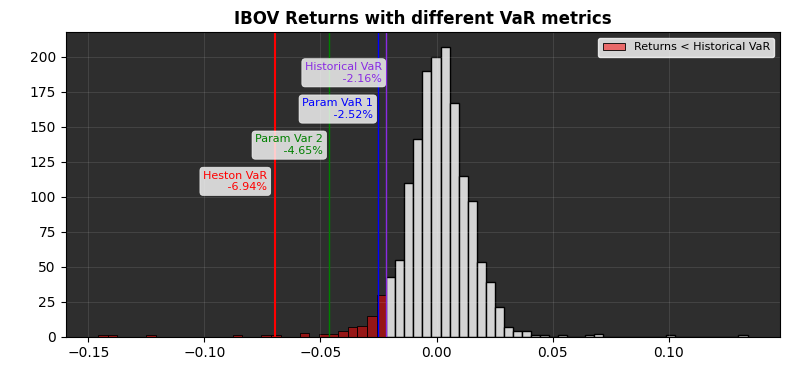

In [ ]:
# Plot histogram
plt.figure(figsize=(8, 4))
ax = plt.gca()
ax.set_facecolor('#2e2e2e')

returns = ibov_df['Returns']

# Highlight values below Historical VaR
sns.histplot(returns[returns >= hist_var], bins=40, kde=False, alpha=0.8, color='white')
sns.histplot(returns[returns < hist_var], bins=30, kde=False, color='red', alpha=0.5, label='Returns < Historical VaR')

# Add vertical lines for VaR
plt.axvline(hist_var, color='blueviolet', linewidth=1)
plt.axvline(param_var, color='blue', linewidth=1)
plt.axvline(param_var_rol, color='green', linewidth=1)
plt.axvline(Heston_var, color='red', linewidth=1.5)

# Add annotations for each VaR line
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="white", lw=0.5, alpha=0.8)
y_pos = ax.get_ylim()[1] * 0.95
plt.text(hist_var*1.08, y_pos*0.95, f'Historical VaR\n {hist_var*100:.2f}%', color='blueviolet', ha='right', va='top', fontsize=8, bbox=bbox_props)
plt.text(param_var*1.08, y_pos*0.75, f'Param VaR 1\n {param_var*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=8, bbox=bbox_props)
plt.text(param_var_rol*1.05, y_pos*0.7, f'Param Var 2\n {param_var_rol*100:.2f}%', color='green', ha='right', va='top', fontsize=8, bbox=bbox_props)
plt.text(Heston_var*1.05, y_pos*0.5, f'Heston VaR\n {Heston_var*100:.2f}%', color='red', ha='right', va='bottom', fontsize=8, bbox=bbox_props)

# Labels and grid
plt.xlabel('Daily Returns (%)', fontweight='semibold', color='white')
plt.ylabel('Frequency', fontweight='semibold', color='white')
plt.title('IBOV Returns with different VaR metrics', fontdict={'fontweight': 'bold', 'color': 'black'})
plt.grid(alpha=0.1, color='white')
plt.legend(fontsize=8, facecolor='white', edgecolor='white', labelcolor='black')

plt.tight_layout()
plt.show()


# Tariffs Returns

This last step we fetch recent data to observe the drop due to the Trump-era tariff uncertainty, triggering market stress and volatility. This event underscores the need for robust risk measures: while standard VaR models (historical/parametric) estimate 2–4% daily losses, the Heston model’s stochastic volatility captures deeper tail risks, better reflecting extreme conditions.

In [147]:
ticker='BOVA11.SA'
start='2025-03-01'

data = yf.download(ticker, start='2025-03-01', end='2025-04-14', progress=False, auto_adjust = True)
data = data.xs((ticker), level="Ticker", axis=1)['Close'].to_frame()
data['Returns'] = data.pct_change()
data['Log Returns'] = np.log(1 + data['Returns'])*100


data['Log Returns'].describe()

,Log Returns
count,27.000000
mean,0.141344
std,1.278485
min,-3.212652
25%,-0.621391
50%,0.157483
75%,0.854381
max,2.858619
